## 2. Masking AKA Clipping with Rasterio

Okay--I admit this is slightly complicated, but doing GIS in the wild can be that way sometimes!  

There's a bunch of ways you may want to clip something, so consider this a primer on what it really takes to clip a raster.  
Essentially, you need:
1. An input image
2. Something you want to clip it with, in this case, we'll use geometries from a shapefile
3. You need the geometry of the clipping object as a [geojson-like dict](https://rasterio.readthedocs.io/en/stable/api/rasterio.mask.html)
4. And of course you need all of the critical descriptive information to go along with these such as the CRS, the transformation, the width, the height, the color profile...  

Let's do it!

In [1]:
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask #this is the masking aka clip module
import matplotlib.pyplot as plt
import geopandas as gpd #to read the input shapefile
import shapely #to transform extent into coordinate geometries
import json
import os

Important: only run this once or you'll wind up in the wrong directory.
```python
os.chdir('../')
os.getcwd()
```

First, let's read in the image:
```python
src = rio.open('workshopdata/NAIP_Boulder.tif')
```

In [64]:
src = rio.open('workshopdata/NAIP_Campus.tif')

Let's take a peek:
```python
show(src.read(1))
```

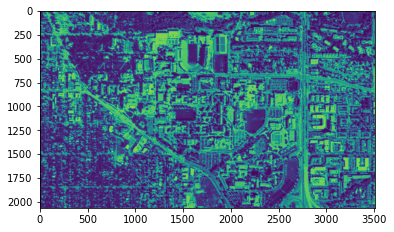

<AxesSubplot:>

In [65]:
show(src.read(1))

Let's clip so that we're only working with the quad area...

Read in the campus shapefile:
```python
shape = gpd.read_file('workshopdata/UCB_MainCampus_Boundaries.shp')
```

In [4]:
shape = gpd.read_file('workshopdata/UCB_MainCampus_Boundaries.shp')

Let's take a look:
```python
shape.plot(figsize = (12,12))
```

<AxesSubplot:>

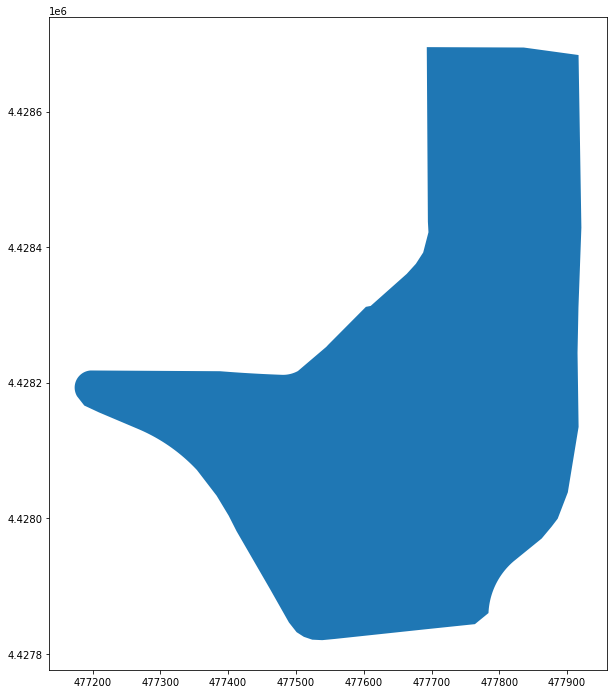

In [79]:
shape[22:23].plot(figsize = (12,12))

Okay, but if we're going to clip with this, it needs to be in the same CRS as the image, this is easy to change using geopandas:
```python
src.crs
```

In [80]:
src.crs

CRS.from_epsg(26913)

Change it to EPSG 26913
```python
shape = shape.to_crs(26913)
```

In [81]:
shape = shape.to_crs(26913)

Now, let's get the geometry of the southwest part of main campus:


We'll use GeoPandas to access the geometry of that particular feature. 
```python
swQuad = shape.geometry[22]
```

In [92]:
swQuad = shape.geometry[22]

### Okay... 

From the Rasterio docs: The values must be a GeoJSON-like dict or an object that implements the Python geo interface protocol (such as a [Shapely](https://shapely.readthedocs.io/en/stable/geometry.html) Polygon). 

Fortunately, that's what we have:
```python
print(swQuad)
```

In [93]:
print(swQuad)

POLYGON ((477547.8159370111 4428256.238502387, 477603.2191063287 4428311.991142652, 477610.260153695 4428313.372457464, 477663.4512336894 4428360.636259837, 477676.9024611069 4428375.471382552, 477687.7264066462 4428392.210929826, 477695.4980979763 4428422.068033623, 477694.6469493901 4428437.489914686, 477693.0019507 4428695.097440739, 477835.9787919673 4428694.515272426, 477916.8683550697 4428683.440503193, 477921.0539890607 4428429.005324838, 477916.7407354645 4428311.39728243, 477915.3693515466 4428244.320595865, 477916.9353471698 4428134.864784565, 477901.0624630528 4428038.386414838, 477886.135831317 4427999.586153438, 477877.0739491967 4427987.72881689, 477862.4903698746 4427970.25427815, 477820.7270960809 4427936.344001541, 477819.520040813 4427935.282557529, 477818.3290782706 4427934.203029216, 477817.154509462 4427933.105614842, 477815.9966359601 4427931.990612612, 477814.8557593446 4427930.858320715, 477813.7319806968 4427929.708938523, 477812.6258015168 4427928.542763111, 4

Perfect!  

Now finally, we can run the mask function to get the clipped image. mask() will return two things: the image, and it's affine transformation. You must set crop to True--without it, the image will be the same size but with no values beyond our clip area. Setting crop to True gets rid of those areas:
```python
out_img, out_transform = mask(src, [swQuad], crop=True)
```
** One other caveat: wrap the swQuad variable in square brackets so rasterio knows to treat it like an iterable.

In [95]:
out_img, out_transform = mask(src, [swQuad], crop=True)

Let's take a look...
```python
show(out_img)
```

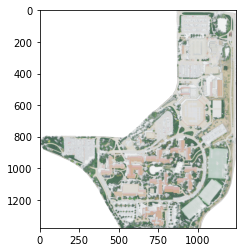

<AxesSubplot:>

In [96]:
show(out_img)

### Cool! 

### ...but...

Okay, maybe you don't want it clipped to the exact geometry... maybe you would rather have it by the extent of the geometry?

Okay, let's do it!

What we'll need is the bounding box geometry of our swQuad shape. We can use geopandas' envelope property:
```python
envelope = swQuad.envelope
envelope
```

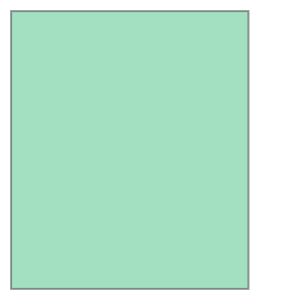

In [97]:
envelope = swQuad.envelope
envelope

print it...

In [98]:
print(envelope)

POLYGON ((477173.6093709322 4427820.357116409, 477921.0539890607 4427820.357116409, 477921.0539890607 4428695.097440739, 477173.6093709322 4428695.097440739, 477173.6093709322 4427820.357116409))


#### Siiiick!

Now, let's do it again, this time with the envelope as the geometry object:
```python
out_img, out_transform = mask(src, [envelope], crop=True)
```

In [99]:
out_img, out_transform = mask(src,[envelope], crop=True)

Check it out:
```python
show(out_img)
```

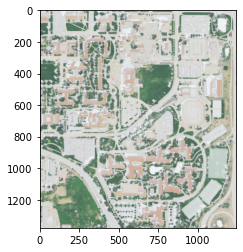

<AxesSubplot:>

In [101]:
show(out_img)

### Awesome. If the color looks funny, we'll sort that out when we save it... 

Now, let's get the original profile
```python
src.profile
```

In [57]:
src.profile

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9590, 'height': 12260, 'count': 4, 'crs': CRS.from_epsg(26913), 'transform': Affine(0.6, 0.0, 473124.0,
       0.0, -0.6, 4434942.0), 'tiled': False, 'interleave': 'pixel'}

Copy it to a variable:
```python
profile = src.profile.copy()
```
(Note, this is the same as the kwargs variable we used in the last notebook)

In [102]:
profile = src.profile.copy()

Grab the height and the width of the output image:
```python
height = out_img.shape[1]
width = out_img.shape[2]
```

In [103]:
height = out_img.shape[1]
width = out_img.shape[2]

Update the profile. Since we have a new transform, a new width & height, we need to use the `.update` method to take the old profile and update certain elements:
```python
profile.update(transform = out_transform, 
               width = width, 
               height = height, 
               photometric = 'rgb', 
               alpha = 'no')
```
(more on photometric & alpha in the next notebook)

In [104]:
profile.update(transform = out_transform, width = width, height = height, photometric = 'rgb', alpha = 'no')

Open a new empty dataset:
```python
new = rio.open('NAIP_swQuad.tif', 'w', **profile)
```

In [105]:
new = rio.open('NAIP_swQuad.tif', 'w', **profile)

Write it to disc:
```python
new.write(out_img)
```

In [106]:
new.write(out_img)

Close it...
```python
new.close()
```

In [107]:
new.close()

#### Done!  